# Выявление профилей потребления для интернет-магазина «Пока все ещё тут»

Интернет-магазин «Пока все ещё тут» продает товары для дома и быта. Нам надо помочь ему сегментировать покупателей. 

Детали проекта:

- Заказчик — менеджер продукта, который отвечает за пользовательский опыт.
- Исследование проводится для создания персонализированных предложений для покупателей (таргетинг).

## Содержание<a name="Содержание"></a>

1. [Загрузка и знакомство с данными](#1.-Загрузка-и-знакомство-с-данными)
2. [Предобработка данных](#2.-Предобработка-данных)
3. [Исследовательский анализ данных](#3.-Исследовательский-анализ-данных)
	1. [За какой период данные](#За-какой-период-данные)
	2. [Сколько клиентов и сколько заказов](#Сколько-клиентов-и-сколько-заказов)
	3. [Категоризация товаров](#Категоризация-товаров)
	4. [Исследование категорий](#Исследование-категорий)
        1. [Сколько товаров продано в каждой категории](#Сколько-товаров-продано-в-каждой-категории)
        2. [Выручка по категориям](#Выручка-по-категориям)
        3. [Распределение категорий по популярности среди покупателей](#Распределение-категорий-по-популярности-среди-покупателей)
        4. [Топ-5 товаров по категориям](#Топ-5-товаров-по-категориям)
        5. [Распределение продаж внутри категорий по времени](#Распределение-продаж-внутри-категорий-по-времени)
4. [Сегментация пользователей](#4.-Сегментация-пользователей)
	1. [Рекомендации для таргетинга](#Рекомендации-для-таргетинга)
5. [Выводы](#5.-Выводы)
	1. [Рекомендации](#Рекомендации)

## 0. Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from io import BytesIO
import requests

In [2]:
pd.set_option('display.max_colwidth', None)
sns.set_palette('pastel')
sns.set_style('darkgrid')

## 1. Загрузка и знакомство с данными<a name="1.-Загрузка-и-знакомство-с-данными"></a>

Сохраним данные в переменную `ecom` и посмотрим на пять первых строк.

In [3]:
ecom = pd.read_csv('ecommerce_dataset.csv')
ecom.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут». Каждый объект в таблице содержит информацию о купленном товаре, а именно:
- `date` — дата покупки;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа, в котором сделана покупка;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

Посмотрим на общую информацию о данных и на их числовое описание.

In [4]:
print('\033[1m' + 'Общая информация' + '\033[0m')
ecom.info()

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [5]:
print('\033[1m' + 'Числовое описание данных' + '\033[0m')
ecom.describe()

Числовое описание данных


,date,order_id,quantity,price
count,6.737000e+03,6737.000000,6737.000000,6737.000000
mean,2.018855e+09,43128.948345,2.501559,462.028499
std,3.855185e+05,27899.414662,15.266478,871.296064
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019020e+09,14827.000000,1.000000,101.000000
50%,2.019050e+09,68503.000000,1.000000,135.000000
75%,2.019061e+09,70504.000000,1.000000,398.000000
max,2.019103e+09,73164.000000,1000.000000,14917.000000


Выводы после первичного изучения данных:
- нам повезло: в датафрейме нет пропусков;
- у признаков неправильные типы:
    - `date` должен быть типа `datetime`;
    - размерности `order_id` и `quantity` можно понизить;
    - `price` можно привести к `int`, так как в данных нет не круглых цен (проверил это отдельно);
- маскимальные значения `quantity` и `price` аномально большие;
- числовые признаки имеют разный масштаб — надо будет стандартизировать, если будем использовать машинное обучения.

[К содержанию](#Содержание)

## 2. Предобработка данных<a name="2.-Предобработка-данных"></a>

### Замена типов данных

Приведем данные к нужным типа и посмотрим на результат.

In [6]:
ecom['date'] = pd.to_datetime(ecom['date'], format='%Y%m%d%H')

for col in ['order_id', 'quantity', 'price']:
    ecom[col] = pd.to_numeric(ecom[col], downcast='unsigned')

ecom.dtypes

date           datetime64[ns]
customer_id            object
order_id               uint32
product                object
quantity               uint16
price                  uint16
dtype: object

Все получилось! Теперь у всех признаков правильные типы.

### Поиск дубликатов

Проверим, есть ли в данных дубликаты.

In [7]:
print('Количество дубликатов:', ecom.duplicated().sum())

Количество дубликатов: 0


Абсолютных дубликатов нет, но я нашел особенность в данных. Есть одинаковые покупки, которые отличаются только датой.

In [8]:
ecom_without_date = ecom.drop('date', axis=1)
print('Дубликаты без учета даты:', ecom_without_date.duplicated().sum())

Дубликаты без учета даты: 1864


Посмотрим на такие заказы.

In [9]:
(ecom[ecom_without_date.duplicated(keep=False)]
 .sort_values(by=['product', 'order_id', 'date'], ascending=[True, True, True])
 .head(10))

,date,customer_id,order_id,product,quantity,price
1999,2019-02-25 09:00:00,075873aa-644c-4a09-9253-204f3156ac7b,70438,"Ёрш унитазный с деревянной ручкой , Ваир 1712012",20,56
2021,2019-02-25 15:00:00,075873aa-644c-4a09-9253-204f3156ac7b,70438,"Ёрш унитазный с деревянной ручкой , Ваир 1712012",20,56
3256,2019-04-28 17:00:00,cce13789-408b-44e1-8147-3c74dc393bf1,14701,Агератум рассада однолетних цветов в кассете по 10 шт,2,210
3306,2019-04-29 15:00:00,cce13789-408b-44e1-8147-3c74dc393bf1,14701,Агератум рассада однолетних цветов в кассете по 10 шт,2,210
4729,2019-06-06 16:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,Алиссум Скальный желтый объем 1 л,1,105
4754,2019-06-07 08:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,Алиссум Скальный желтый объем 1 л,1,105
3257,2019-04-28 17:00:00,cce13789-408b-44e1-8147-3c74dc393bf1,14701,Алиссум рассада однолетних цветов в кассете по 10 шт,2,210
3307,2019-04-29 15:00:00,cce13789-408b-44e1-8147-3c74dc393bf1,14701,Алиссум рассада однолетних цветов в кассете по 10 шт,2,210
4817,2019-06-07 17:00:00,4723417a-8c73-4502-9600-75187124fb5c,71638,Антинакипин для утюгов Ампулы 10 мл по 5 шт UN MOMENTO Россия 4627096350107,1,164
4818,2019-06-07 21:00:00,4723417a-8c73-4502-9600-75187124fb5c,71638,Антинакипин для утюгов Ампулы 10 мл по 5 шт UN MOMENTO Россия 4627096350107,1,164


Между такими заказами проходит немного времени, как правило, меньше суток. Скорее всего, это не новые покупки, а изменение статусов старых: регистрация, поступление в пункт выдачи, оплата или возврат. Оставим только первые записи, а остальные удалим.

Отметим, что таких дубликатов много — больше 27% от всех данных. Стоит расскзать об этом заказчику, выяснить причину и устранить ее.

In [10]:
duplicates_indexes = ecom[ecom_without_date.duplicated(keep='first')].index

ecom = (ecom
        .drop(labels=duplicates_indexes, axis='index')
        .reset_index(drop=True))

### Обработка выбросов

Числовое описание данных показало, что у признаков `quantity` и `price` есть аномально большие значения. Посмотрим диаграммы размаха, чтобы понять, какие покупки считать выбросами.

In [11]:
def plot_boxplot(data, column, xlim, title, xlabel):
    """Функция строит диаграмму размаха с заданными параметрами.
    
    Аргументы:
    data -- датафрейм, по которому надо строить диаграмму.
    column -- колонка датафрейма, из которой надо брать информацию для диаграммы.
    xlim -- отрезок по оси абсцисс, который будет отображен на графике.
    title -- заголовок графика.
    xlabel -- подпись оси абсцисс.

    """
    fig = plt.figure(figsize=(13, 4))    
    sns.boxplot(data=data, x=column)
    plt.xlim(xlim)
    
    plt.title(title, fontsize=17, pad=12)
    plt.xlabel(xlabel, fontsize=14, labelpad=10)
    plt.xticks(fontsize=12.5)
    
    return fig

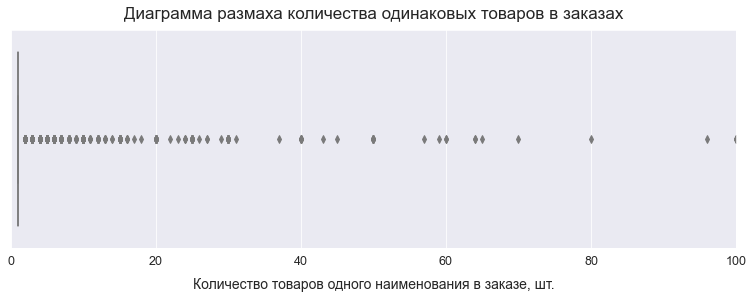

In [12]:
quantity_boxplot = plot_boxplot(data=ecom, column='quantity', xlim=[0, 100],
                                title='Диаграмма размаха количества одинаковых товаров в заказах',
                                xlabel='Количество товаров одного наименования в заказе, шт.')

Диаграмма размаха показывает, что больше 20 штук одного товара за раз заказывают редко.

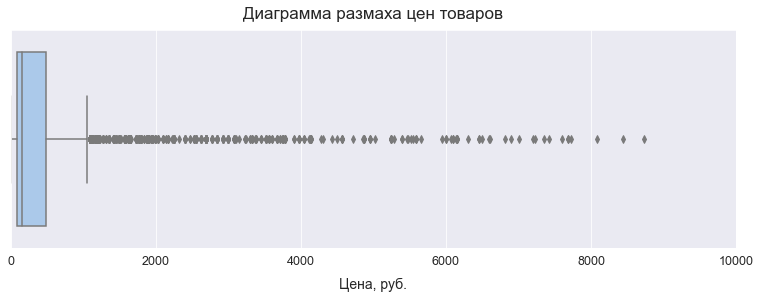

In [13]:
price_boxplot = plot_boxplot(data=ecom, column='price', xlim=[0, 10000],
                             title='Диаграмма размаха цен товаров',
                             xlabel='Цена, руб.')

На этой диаграмме видно, что редко покупают товары дороже 4000 рублей.

Посчитаем, как много данных мы потеряем, если удалим товары, которых больше 20 в одном заказе или которые дороже 4000 рублей.

In [14]:
abnormal_prods = ecom[(ecom['quantity']>10) | (ecom['price']>4000)]
abnormal_num = len(abnormal_prods)
abnormal_share = round(abnormal_num/len(ecom)*100, 2)

In [15]:
print('Число аномальных товаров:', abnormal_num)
print('Доля аномальных товаров: ' + str(abnormal_share) + '%')

Число аномальных товаров: 226
Доля аномальных товаров: 4.64%


Доля аномальных значений при выбранных порогах чуть больше трех процентов. Мы можем пожертвовать этим объемом данных для очистки датасета.

In [16]:
# На всякий случай сохраним полные данные.
ecom_full = ecom

ecom = (ecom
        .drop(abnormal_prods.index)
        .reset_index(drop=True))

### Добавление дополнительных признаков

В будущем нам понадобится полная стоимость позиции в таблице. Рассчитаем этот параметр и добавим его в данные.

In [17]:
ecom['total_position_cost'] = ecom['price'] * ecom['quantity']

ecom.head(3)

,date,customer_id,order_id,product,quantity,price,total_position_cost
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142,142
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194,194
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112,112


На этом предобработка закончена. Можно переходить к исследовательскому анализу данных.

[К содержанию](#Содержание)

## 3. Исследовательский анализ данных<a name="3.-Исследовательский-анализ-данных"></a>

### За какой период данные<a name="За-какой-период-данные"></a>

Посмотрим, данными за какое время мы располагаем.

In [18]:
print(ecom['date'].min())
print(ecom['date'].max())

2018-10-01 00:00:00
2019-10-31 14:00:00


Больше чем за год: с 1 октября 2018 года по 31 октября 2019 года.

### Сколько клиентов и сколько заказов<a name="Сколько-клиентов-и-сколько-заказов"></a>

Посчитаем, сколько клиентов сделали заказы и сколько заказов вообще было сделано.

In [19]:
print('Число клиентов:', ecom['customer_id'].nunique())
print('Число заказов:', ecom['order_id'].nunique())

Число клиентов: 2277
Число заказов: 2580


Число заказов немного больше, чем число клиентов. Значит, в среднем один клиент делает один заказ в год. С ретеншном у нас не очень 😕

### Категоризация товаров<a name="Категоризация-товаров"></a>

Я попробовал выделить категории автоматически с помощью модели DeepPavlov и кластеризации, но у меня не получилось. Я дополнтильно предобрабатывал названия товаров:
1. удалял лишние знаки с помощью регулярных выражений;
2. лемматизировал названия;
3. удалял незначимые слова, например цвета и единицы измерения;
4. добавил в словарь модели самые частые слова, чтобы получить лучшие эмбединги.

Все это мне не помогло 😢 У нас близкие по семантике названия товаров, и модель плохо их различала. Например, она объединяла живые и искусственные растения в одну категорию или муляжи фруктов и семена плодовых культур.

Пришлось самому делить товары на категории.

Сначала я хотел лемматизировать названия, выделить самые частые леммы и категоризовать их. У меня получилось примерно 400 лемм длинной больше 2 символов и которые встречались во всех названиях больше 4 раз. Это относительно немного для ручной обработки, но появились проблемы.
1. Без контекста по одной лемме сложно понять, к какому товару (и следовательно категории) ее отнести.
2. Допустим, я осилил такую категоризацию. Теперь надо определить, по какой лемме из названия присваивать категорию. Я решил, что лучший вариант — использовать самую редко встречающуюся лемму, потому что она точнее всего определяет товар. Значит, надо в каждую строчку датафрейма добавить информацию частотности лемм. Это возможно, но это большая головная боль и непонятно какой результат на выходе.

Из-за этих причин я выбрал более простой и менее умный вариант:
- Из каждого названия я выделил первые два слова. Это уменьшило число уникальных названий в 2,5 рааз — c 2300 до 900.
- Затем создал датафрейм, в котором оставил только уникальные словосочетание и строки, соответсвующие им.
- Выгрузил их в гугл-таблицы, отсортировал по алфавиту и поделил на категории там.
- В гугл-таблицах я сделал еще несколько оптмизаций, чтобы ускорить процесс, но это не так важно.
- Спустя три часа я все разметил. Повезло, что было много одинаковых товаров с разными характеристиками: они стояли рядом и я быстро размечал их растягиванием ячейки. Не повезло, что половину данных составляли названия растений и приходилось гуглить, домание они или садовые. Иногда с этим помогали полные названия и цены.
- В конце я скачал таблицу с категорями, залил ее в тетрадку и соединил с основным датафреймом по столбцу с двумя первыми словами.

Всего у меня получилось десять категорий:
1. рассада и саженцы,
2. комнатные растения,
3. искусственные растения и муляжи,
4. посуда и кухонные принадлежности,
5. гигиена и товары для ванной,
6. товары для спальни,
7. хранение и порядок,
8. сумки и тележки,
9. бытовая химия и уборка,
10. ремонт.

Ниже идет код для всего вышеописанного и короткие комментарии к нему.

Создаю функцию для извлечения первых двух слов из текста.

In [20]:
def extract_first_two_words(text):
    """Функция извекает из текста первые два слова. Если слово всего одно, то только его.
    
    Аргументы:
    text -- текст, из которого надо извлечь первые слова.

    """
    words_list = text.split()
    
    for word in words_list:
        if len(words_list) >= 2:
            result = words_list[0] + ' ' + words_list[1]
        else:
            result = words_list[0]
    
    return result        

С помощью этой функцию извлекаю из названий первые слова и сохраняю их в колонку `first_two_words`.

In [21]:
ecom['first_two_words'] = ecom['product'].apply(extract_first_two_words)
ecom.head(3)

,date,customer_id,order_id,product,quantity,price,total_position_cost,first_two_words
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142,142,Комнатное растение
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194,194,Комнатное растение
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112,112,Радермахера d-12


Готовлю таблицу для скачивания и скачиваю ее.

In [22]:
ecom_export = (ecom[['product', 'first_two_words', 'price']]
               .drop_duplicates(subset='first_two_words')
               .reset_index(drop=True))

ecom_export.to_csv('first_two_words.csv', sep='\t')

*Загружаю таблицу в гугл-таблицы и разбиваю там товары на категории.*

Скачиваю [результат](https://docs.google.com/spreadsheets/d/1Ho1IWAEON12fVio-Bxsd6an3ARL4R9EzjKYOU_OC8eE/edit#gid=1463450820) из гугл-таблицы, добавляю его в проект и соединяю с исходным `ecom`.

In [23]:
spreadsheet_id = '1Ho1IWAEON12fVio-Bxsd6an3ARL4R9EzjKYOU_OC8eE'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

ecom_categorized = pd.read_csv(BytesIO(r.content))

ecom_categories = ecom_categorized[
    ['first_two_words', 'category', 'category_num']]

ecom = ecom.merge(ecom_categories, how='left', on='first_two_words')

ecom.sample(3)

,date,customer_id,order_id,product,quantity,price,total_position_cost,first_two_words,category,category_num
2454,2019-04-23 14:00:00,58a966e2-b773-4ddd-aeff-472f8320a6a3,14679,Пеларгония розебудная Red Pandora укорененный черенок,1,135,135,Пеларгония розебудная,комнатные растения,2
61,2018-10-03 10:00:00,d0c6d3d9-dc3b-4406-afb7-f6cb0da3a4a9,68515,"Корзина пластиковая для белья 60л. с крышкой бежевая 1860/2, Виолет",1,592,592,Корзина пластиковая,хранение и порядок,4
1234,2019-01-16 15:00:00,fb2f95f0-1f30-4e6a-a75c-92d1e2d341e3,69850,"Сушилка для белья на батарею, СБ5-45, НИКА",1,134,134,Сушилка для,гигиена и товары для ванной,8


Категории на месте — ура!

[К содержанию](#Содержание)

### Исследование категорий<a name="Исследование-категорий"></a>

#### Сколько товаров продано в каждой категории<a name="Сколько-товаров-продано-в-каждой-категории"></a>

Посмотрим, сколько товаров продано в каждой категории. Не число уникальных наименований в каждой категории, а именно количество проданных товаров.

In [24]:
categories_quantity = (ecom
                       .groupby('category')
                       .agg({'quantity':'sum'})
                       .reset_index()
                       .sort_values(by='quantity', ascending=False))

categories_quantity['share'] = round(
    categories_quantity['quantity']/categories_quantity['quantity'].sum()*100, 2)
categories_quantity['share'] = categories_quantity['share'].astype(str) + '%'

categories_quantity.reset_index(drop=True, inplace=True)
categories_quantity

,category,quantity,share
0,рассада и саженцы,2034,28.73%
1,комнатные растения,1404,19.83%
2,посуда и кухонные принадлежности,830,11.72%
3,искусственные растения и муляжи,725,10.24%
4,гигиена и товары для ванной,683,9.65%
5,бытовая химия и уборка,514,7.26%
6,сумки и тележки,317,4.48%
7,хранение и порядок,290,4.1%
8,товары для спальни,164,2.32%
9,ремонт,118,1.67%


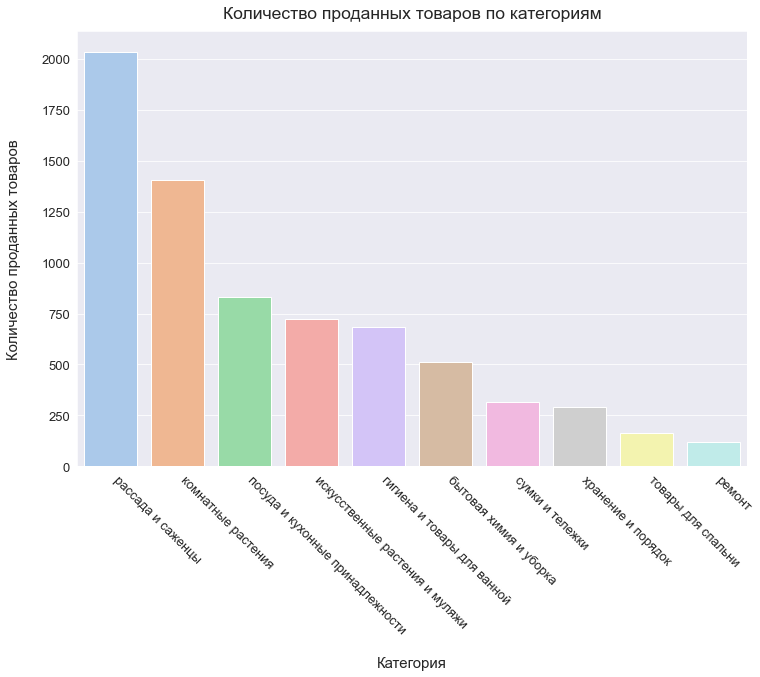

In [25]:
categories_quantity_plot = plt.figure(figsize=(12, 8))
ax = sns.barplot(x='category', y='quantity', data=categories_quantity)

plt.title('Количество проданных товаров по категориям', fontsize=17.5, pad=13)
plt.xlabel('Категория', fontsize=15, labelpad=20)
plt.ylabel('Количество проданных товаров', fontsize=15, labelpad=20)
plt.xticks(rotation=-45, ha="left", fontsize=13)
plt.yticks(fontsize=13)

plt.show()

Почти половина проданных товаров — растения: 28,7% занимают рассада и саженцы и 19,8% — комнатные растения. Также популярны искусственные растения: на них пришлось 10% продаж.

Из товаров, не связанных с растениями, популярны кухонные и ванные принадлежности. Доля проданных товаров в этих категориях — 10-11%.

#### Выручка по категориям<a name="Выручка-по-категориям"></a>

Теперь посмотрим, сколько денег принесла каждая категория.

In [26]:
categories_revenue = (ecom
                          .groupby('category')
                          .agg({'total_position_cost':'sum'})
                          .reset_index()
                          .sort_values(by='total_position_cost', ascending=False))

categories_revenue['share'] = round(
    categories_revenue['total_position_cost']/categories_revenue['total_position_cost'].sum()*100, 2)
categories_revenue['share'] = categories_revenue['share'].astype(str) + '%'

categories_revenue.reset_index(drop=True, inplace=True)
categories_revenue

,category,total_position_cost,share
0,гигиена и товары для ванной,500762.0,20.1%
1,сумки и тележки,444166.0,17.83%
2,бытовая химия и уборка,358093.0,14.38%
3,посуда и кухонные принадлежности,299639.0,12.03%
4,комнатные растения,263796.0,10.59%
5,рассада и саженцы,219155.0,8.8%
6,хранение и порядок,142247.0,5.71%
7,товары для спальни,126968.0,5.1%
8,ремонт,95262.0,3.82%
9,искусственные растения и муляжи,40978.0,1.64%


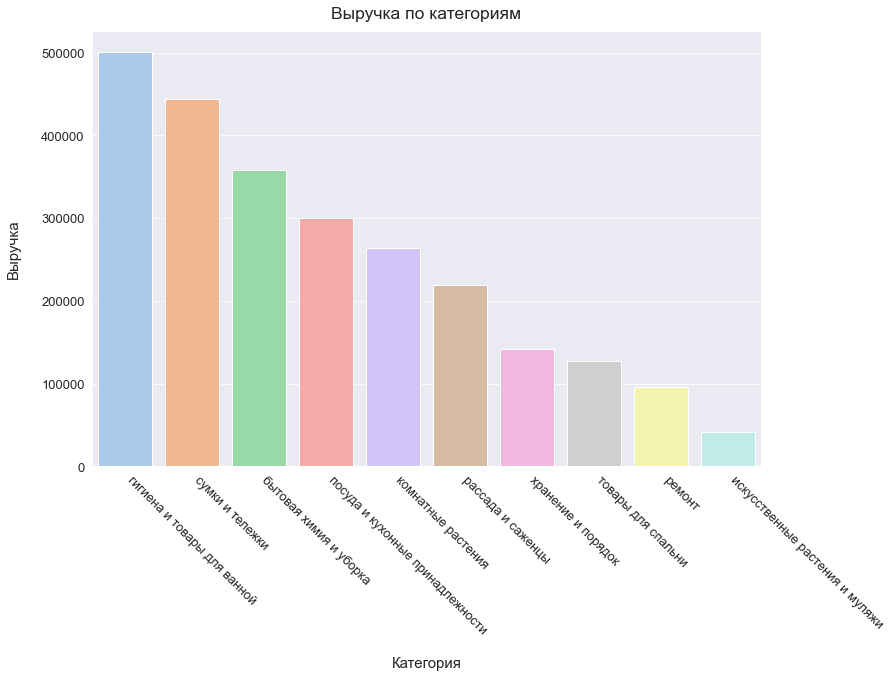

In [27]:
categories_revenue_plot = plt.figure(figsize=(12, 8))
ax = sns.barplot(x='category', y='total_position_cost', data=categories_revenue)

plt.title('Выручка по категориям', fontsize=17.5, pad=13)
plt.xlabel('Категория', fontsize=15, labelpad=20)
plt.ylabel('Выручка', fontsize=15, labelpad=20)
plt.xticks(rotation=-45, ha="left", fontsize=13)
plt.yticks(fontsize=13)

plt.show()

Здесь растения уже не на первых местах. Это объясняется тем, что средняя цена купленного наименования у растения самая низкая из всех категорий:

In [28]:
category_mean_price = (ecom
 .groupby('category')
 .agg({'price':'mean'})
 .sort_values(by='price', ascending=True)
)

category_mean_price

,price
category,
искусственные растения и муляжи,70.447699
рассада и саженцы,120.500000
комнатные растения,188.855153
посуда и кухонные принадлежности,485.949495
гигиена и товары для ванной,814.400369
товары для спальни,854.540541
бытовая химия и уборка,859.035813
хранение и порядок,877.050000
ремонт,1197.831169


#### Распределение категорий по популярности среди покупателей<a name="Распределение-категорий-по-популярности-среди-покупателей"></a>

Чтобы определить популярность категории, посмотрим, сколько клиентов купили хотя бы один товар в ней.

In [29]:
categories_n_buyers = (ecom
                          .groupby('category')['customer_id']
                          .nunique()
                          .reset_index()
                          .rename(columns={
                              'customer_id':'n_buyers'})
                          .sort_values(by='n_buyers', ascending=False))

categories_n_buyers['share'] = round(
    categories_n_buyers['n_buyers']/categories_n_buyers['n_buyers'].sum()*100, 2)
categories_n_buyers['share'] = categories_n_buyers['share'].astype(str) + '%'

categories_n_buyers.reset_index(drop=True, inplace=True)
categories_n_buyers

,category,n_buyers,share
0,комнатные растения,452,18.47%
1,гигиена и товары для ванной,439,17.94%
2,посуда и кухонные принадлежности,313,12.79%
3,бытовая химия и уборка,294,12.01%
4,сумки и тележки,272,11.12%
5,рассада и саженцы,265,10.83%
6,искусственные растения и муляжи,145,5.93%
7,хранение и порядок,105,4.29%
8,товары для спальни,96,3.92%
9,ремонт,66,2.7%


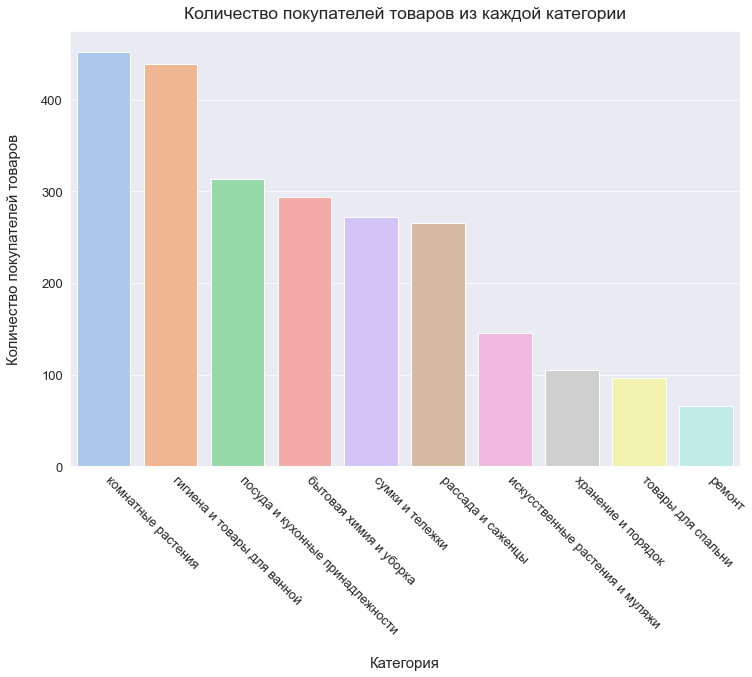

In [30]:
categories_n_buyers_plot = plt.figure(figsize=(12, 8))
ax = sns.barplot(x='category', y='n_buyers', data=categories_n_buyers)

plt.title('Количество покупателей товаров из каждой категории', fontsize=17.5, pad=13)
plt.xlabel('Категория', fontsize=15, labelpad=20)
plt.ylabel('Количество покупателей товаров', fontsize=15, labelpad=20)
plt.xticks(rotation=-45, ha="left", fontsize=13)
plt.yticks(fontsize=13)

plt.show()

Вместе с графиком количества проданных товаров по категориям этот дает пониманием, сколько в среднем товаров в каждой категории покупают клиенты. Для удобства выведем этот показатель в таблице.

In [31]:
cat_mean_n_buyed_products = categories_quantity
cat_mean_n_buyed_products = (cat_mean_n_buyed_products
                             .merge(categories_n_buyers, how='left', on='category'))
cat_mean_n_buyed_products.drop(columns=['share_x', 'share_y'], inplace=True)

cat_mean_n_buyed_products['mean_n_buyed_products'] = \
     cat_mean_n_buyed_products['quantity'] / cat_mean_n_buyed_products['n_buyers']

cat_mean_n_buyed_products

,category,quantity,n_buyers,mean_n_buyed_products
0,рассада и саженцы,2034,265,7.675472
1,комнатные растения,1404,452,3.106195
2,посуда и кухонные принадлежности,830,313,2.651757
3,искусственные растения и муляжи,725,145,5.000000
4,гигиена и товары для ванной,683,439,1.555809
5,бытовая химия и уборка,514,294,1.748299
6,сумки и тележки,317,272,1.165441
7,хранение и порядок,290,105,2.761905
8,товары для спальни,164,96,1.708333
9,ремонт,118,66,1.787879


#### Топ-5 товаров по категориям<a name="Топ-5-товаров-по-категориям"></a>

Чтобы таргетологи знали, какие товары советовать, найдем топ-5 самых популярных в каждой категории.

In [32]:
cat_list = ['комнатные растения', 'рассада и саженцы',
            'посуда и кухонные принадлежности', 
            'бытовая химия и уборка', 'сумки и тележки',
            'гигиена и товары для ванной', 'искусственные растения и муляжи',
            'хранение и порядок', 'товары для спальни', 'ремонт']

In [33]:
for category in cat_list:
    top_products = (ecom[ecom['category']==category]
                    .groupby('product')['customer_id']
                    .nunique()
                    .reset_index()
                    .rename(columns={
                        'customer_id':'n_buyers'})
                    .sort_values(by='n_buyers', ascending=False)
                    .reset_index(drop=True)
                    .head(5))
    print()
    print('\033[1m' + 'Топ-5 популярных товаров в категории "' + category + '"' + '\033[0m')
    display(top_products)


Топ-5 популярных товаров в категории "комнатные растения"


,product,n_buyers
0,Пеларгония розебудная Red Pandora укорененный черенок,63
1,Пеларгония розебудная Prins Nikolai укорененный черенок,54
2,Пеларгония зональная диам. 12 см сиреневый полумахровый,47
3,Пеларгония розебудная Mary укорененный черенок,35
4,Пеларгония розебудная Margaretha укорененный черенок,29



Топ-5 популярных товаров в категории "рассада и саженцы"


,product,n_buyers
0,"Однолетнее растение Петуния махровая в кассете 4 шт, Россия",19
1,Петуния махровая рассада однолетних цветов в кассете по 6 шт,15
2,Петуния махровая рассада однолетних цветов в кассете по 10 шт,13
3,Рассада зелени для кухни Розмарина в горшке диам. 9 см,13
4,Рассада зелени для кухни Розмарин Блю Лагун диам. 9 см,13



Топ-5 популярных товаров в категории "посуда и кухонные принадлежности"


,product,n_buyers
0,"Кувшин пластмассовый с крышкой ""Кумган"" 2,0 л 1408003",5
1,"Измельчитель овощей ручной ШК-4 деревянный, 3 ножа, 1516020",4
2,Салатник Luminarc КУТЮР 27 см H3529,4
3,Контейнер для овощей Полимербыт 3-х секционный лоток 9 л 4312600,3
4,"Коврик интерьерный для кухни La Bruschetta из ПВХ прямоугольный 45х75 см, Apache, 4661",3



Топ-5 популярных товаров в категории "бытовая химия и уборка"


,product,n_buyers
0,Подкладка под чехол Zalger 520114 135х50 см войлок,7
1,Гладильная доска НИКА BLUES 124х46 см 5757,7
2,Подкладка под чехол Zalger 520140 135х50 см поролон,6
3,Подрукавник складной Ника П,6
4,"Гладильная доска НИКА ДСП ЭКОНОМ 106,5х29 ЭК1",6



Топ-5 популярных товаров в категории "сумки и тележки"


,product,n_buyers
0,Сумка-тележка 2-х колесная Gimi Argo синяя,43
1,Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,16
2,Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,14
3,Тележка багажная DELTA ТБР-20 черный с серым грузоподъемность 25 кг сумка 50 кг каркас РОССИЯ,10
4,Сумка-тележка 2-х колесная складная Gimi Flexi зеленая,10



Топ-5 популярных товаров в категории "гигиена и товары для ванной"


,product,n_buyers
0,Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м,16
1,"Таз пластмассовый со стиральной доской (Иж), 1404021",10
2,"Сушилка для белья потолочная Лиана 2,0 м 1703009",10
3,"Сушилка для белья потолочная Лиана 2,4 м 1703011",9
4,Сушилка для белья напольная НИКА СБП1/С 18 м,9



Топ-5 популярных товаров в категории "искусственные растения и муляжи"


,product,n_buyers
0,Муляж Баклажан 18 см,10
1,Муляж Зеленое яблоко полиуретан d-6 см,8
2,Муляж Персики мини полиуретан d-6 см,8
3,Муляж Морковь 16 см,6
4,Муляж Желудь 2 шт,6



Топ-5 популярных товаров в категории "хранение и порядок"


,product,n_buyers
0,Полки QWERTY Торонто белый 40х10 см 35х10 см 30х10 см 25х10 см 72015,3
1,Подставка для обуви резиновая Attribute 80x40 см AMC080,3
2,Вешалка-плечики без эссенции цвет тёмно-розовый FWM-002/Quartz pink,3
3,Полки QWERTY Италия белый/серый 40х14х10 см 35х10х10 см 30х7х10 см 72006,3
4,"Корзина пластиковая для белья 40л. с крышкой белая 1840/06, Виолет",2



Топ-5 популярных товаров в категории "товары для спальни"


,product,n_buyers
0,Коврик хлопковый 40х60 см цвета в ассортименте 6194,4
1,"Коврик придверный хлопковый 60х140 см мультиколор, Helex, С04",4
2,"Коврик придверный с дизайном, из резины и кокоса 58,5*89 Gothic Iron Slice / Готический Узор, 4468",4
3,Корзина для белья ВИОЛЕТ с крышкой Ротанг 40 л латте 1840/20,3
4,"Коврик придверный MOHAWK Mansonry Foliage Листопад 58,5х89 см 5412",3



Топ-5 популярных товаров в категории "ремонт"


,product,n_buyers
0,"Стяжка оконная с болтом СТ-55 цинк, 1108354",3
1,Стремянка 5 ступенчатая Hailo 8925-901 L9 алюминиевая,2
2,Стремянка COLOMBO FACTOTUM 4 ступени стальная G110L04W,2
3,Стремянка DOGRULAR КЛАСС ПЛЮС 4 ступени 123304,2
4,Стремянка бытовая Framar Slimmy 4 ступени,2


#### Распределение продаж внутри категорий по времени<a name="Распределение-продаж-внутри-категорий-по-времени"></a>

Узнаем, есть ли сезонность в продажах товаров из ассортимента нашего магазина.

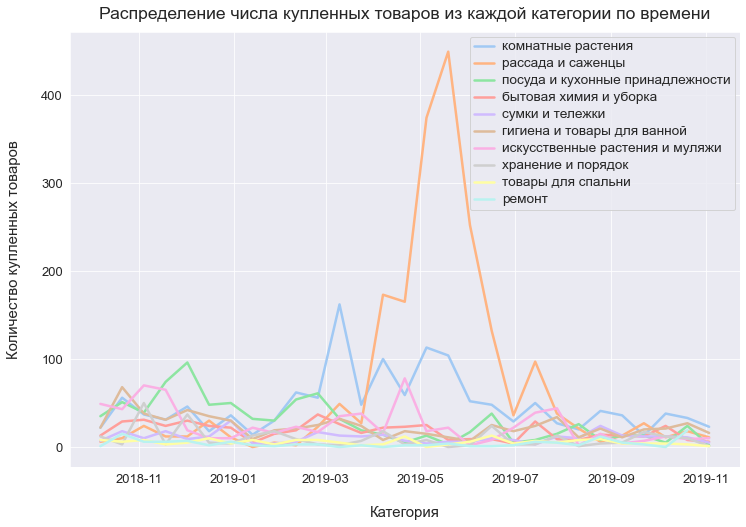

In [34]:
purchases_per_cat = plt.figure(figsize=(12, 8))

for category in cat_list:
    season = (ecom[ecom['category']==category]
                  .groupby(['date', 'product'])['quantity']
                  .sum())
    
    season = season.reset_index()
    season.set_index(keys='date', drop=True, inplace=True)
    
    season = season.resample('2W').sum().reset_index()
    ax = sns.lineplot(data=season, x='date', y='quantity', label=category, linewidth=2.5)
    plt.setp(ax.get_legend().get_texts(), fontsize='13.7')
    plt.setp(ax.get_legend().get_title(), fontsize='1000')
    
plt.title('Распределение числа купленных товаров из каждой категории по времени', fontsize=17.5, pad=13)
plt.xlabel('Категория', fontsize=15, labelpad=20)
plt.ylabel('Количество купленных товаров', fontsize=15, labelpad=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
    
plt.show()

Больше всего сезонности подвержены рассада и саженцы. С середины марта до конца июля их покупают гораздо чаще, чем в другое время года. Пик продаж — в июне.

Это логичная закономерность, потому что период повышенного спроса начинается с сезонном посадок, а пик приходится на начало дачного времени. 

Гораздо маньший всплеск, но с похожими временными рамками наблюдается в продажах комнатных растений. Возможно, горожане хотят устроить себе дачу дома (🙂) или я не все растения правильно классифицировал. Интересно, что здесь повышенный интерес начинантся с пика в начале марта. Скорее всего, он связан с Международным женским днем 8 марта, когда комнатные растения покупают в качестве подарка.

[К содержанию](#Содержание)

## 4. Сегментация пользователей<a name="4.-Сегментация-пользователей"></a>

Делить клиентов на сегменты будем на основе их покупок. Сегменты будут такими же, как категории товаров. Будем считать, что покупатель относится к тому сегменту, в соответсвующей категории которого он купил больше всего товаров.

Еще один способ присвоить сегменты — назначать их не по категории, где совершенно больше всего покупок, а по той, в которой покупатель потратил больше всего денег. Ведь магазины, как правило, ориентируются на выручку, а не на число проданных товаров, хоть показатели и связаны.

Мне кажется, что для таргетинга количество покупок в категории лучше характеризирует пользователя, чем потраченная на категорию сумма. Также этот показатель лучше сработает конкретно в нашем случае потому, что у нас много популярных, но дешевых товаров — а именно растений. Если назначать категорию по выручке, то дорогие категории могут «затмить» эту популярность.

Итак, рассчитаем, сколько товаров в каждой категории покупали клиенты.

In [35]:
segmentation = (ecom
                .groupby(['customer_id', 'category'])
                .agg({'product':'count'})
                .reset_index())

segmentation.head(5)

,customer_id,category,product
0,000d6849-084e-4d9f-ac03-37174eaf60c4,комнатные растения,4
1,001cee7f-0b29-4716-b202-0042213ab038,гигиена и товары для ванной,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,бытовая химия и уборка,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,сумки и тележки,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,хранение и порядок,1


Отсортируем таблицу по числу покупок в категории и для наглядности по идентификатору пользователя.

In [36]:
segmentation = (segmentation
                .sort_values(by=['product', 'customer_id'],
                             ascending=[False, True]))

segmentation.head(5)

,customer_id,category,product
2020,d3b9ffea-d143-4747-8d59-74ab843d1ad6,рассада и саженцы,51
1904,c971fb21-d54c-4134-938f-16b62ee86d3b,гигиена и товары для ванной,35
375,2a0acc09-e343-4f92-b5c0-f598ef2b07d4,рассада и саженцы,31
571,3d5fef90-4a65-4a7e-84cf-010eba7b038d,рассада и саженцы,30
1523,a3394ff2-4cd2-4332-9f6c-2668ac608fbc,рассада и саженцы,30


In [37]:
segmentation[segmentation.duplicated(subset=['customer_id'])].head(5)

,customer_id,category,product
1903,c971fb21-d54c-4134-938f-16b62ee86d3b,бытовая химия и уборка,23
1906,c971fb21-d54c-4134-938f-16b62ee86d3b,комнатные растения,23
1910,c971fb21-d54c-4134-938f-16b62ee86d3b,сумки и тележки,18
1105,760aa067-90c3-4794-b7a9-a8831197388b,рассада и саженцы,15
1907,c971fb21-d54c-4134-938f-16b62ee86d3b,посуда и кухонные принадлежности,14


Теперь клиент первый раз встречается в таблице с категорией, в которой он совершил больше всего покупок. Это значит, что мы можем удалить остальные его «вхождения» и тогда столбец `category` будет отображать сегмент клиента.

У метода `drop_duplicates()` есть параметр `keep`, который позволяет выбрать, какой дубликат в колонке оставить. Поэтому мы можем осуществить нашу идею.

In [38]:
segmentation = (segmentation
                .drop_duplicates(subset='customer_id', keep='first')
                .reset_index(drop=True))

segmentation

,customer_id,category,product
0,d3b9ffea-d143-4747-8d59-74ab843d1ad6,рассада и саженцы,51
1,c971fb21-d54c-4134-938f-16b62ee86d3b,гигиена и товары для ванной,35
2,2a0acc09-e343-4f92-b5c0-f598ef2b07d4,рассада и саженцы,31
3,3d5fef90-4a65-4a7e-84cf-010eba7b038d,рассада и саженцы,30
4,a3394ff2-4cd2-4332-9f6c-2668ac608fbc,рассада и саженцы,30
...,...,...,...
2272,ff601403-b094-4b86-9ac6-264d725b9277,сумки и тележки,1
2273,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,гигиена и товары для ванной,1
2274,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,рассада и саженцы,1
2275,ffb80538-3fda-4351-8ea9-9d2bec58bb07,гигиена и товары для ванной,1


В таблице осталось 2277 записей. Ровно столько, сколько клиентов в таблице `ecom`. Значит, наша идея сработала правильно.

Переименуем колонку `category` в `segment` и удалим столбец `product`, так как он нам больше не нужен.

In [39]:
segmentation = segmentation.drop(columns='product')
segmentation = segmentation.rename(columns={'category':'segment'})

segmentation.head(5)

,customer_id,segment
0,d3b9ffea-d143-4747-8d59-74ab843d1ad6,рассада и саженцы
1,c971fb21-d54c-4134-938f-16b62ee86d3b,гигиена и товары для ванной
2,2a0acc09-e343-4f92-b5c0-f598ef2b07d4,рассада и саженцы
3,3d5fef90-4a65-4a7e-84cf-010eba7b038d,рассада и саженцы
4,a3394ff2-4cd2-4332-9f6c-2668ac608fbc,рассада и саженцы


Добавим сегмент клиента в таблицу `ecom`. Для этого соединим ее с `segmentation` по номеру пользователя.

In [40]:
ecom = ecom.merge(right=segmentation, on='customer_id')

ecom.head(5)

,date,customer_id,order_id,product,quantity,price,total_position_cost,first_two_words,category,category_num,segment
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142,142,Комнатное растение,комнатные растения,2,комнатные растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194,194,Комнатное растение,комнатные растения,2,комнатные растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112,112,Радермахера d-12,комнатные растения,2,комнатные растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179,179,Хризолидокарпус Лутесценс,комнатные растения,2,комнатные растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112,112,Циперус Зумула,комнатные растения,2,комнатные растения


Отлично, покупателей сегментировали. Теперь перейдем к рекомендациям для таргетинга.

[К содержанию](#Содержание)

### Рекомендации для таргетинга<a name="Рекомендации-для-таргетинга"></a>

Посмотрим, в каких еще категориях, кроме «сегментной», клиенты делали покупки. То есть построим матрицу корреляций между сегментами пользователей и категориями, в которых они делали покупки. 

Но сначала рассчитаем размеры сегментов. Они пригодятся нам дальше.

In [41]:
segments_sizes = (segmentation['segment']
                  .value_counts()
                  .reset_index())
segments_sizes.columns = ['segment', 'size']

segments_sizes

,segment,size
0,гигиена и товары для ванной,421
1,комнатные растения,408
2,посуда и кухонные принадлежности,292
3,бытовая химия и уборка,286
4,сумки и тележки,264
5,рассада и саженцы,235
6,искусственные растения и муляжи,140
7,хранение и порядок,90
8,товары для спальни,83
9,ремонт,58


Теперь подготовим таблицу, по которой будем строить матрицу корреляции. Выделим из `ecom` столбцы `customer_id`, `category` и `segment`. Затем удалим из новой таблицы дубликаты. После этого таблица будет хранить информацию о том, к какому сегменту относится клиент и в каких категориях он хотя бы раз совершал покупки.

In [42]:
prep_for_recs = ecom[['customer_id', 'segment', 'category']]
prep_for_recs = prep_for_recs.drop_duplicates().reset_index(drop=True)

prep_for_recs

,customer_id,segment,category
0,ee47d746-6d2f-4d3c-9622-c31412542920,комнатные растения,комнатные растения
1,375e0724-f033-4c76-b579-84969cf38ee2,гигиена и товары для ванной,гигиена и товары для ванной
2,6644e5b4-9934-4863-9778-aaa125207701,гигиена и товары для ванной,гигиена и товары для ванной
3,c971fb21-d54c-4134-938f-16b62ee86d3b,гигиена и товары для ванной,бытовая химия и уборка
4,c971fb21-d54c-4134-938f-16b62ee86d3b,гигиена и товары для ванной,гигиена и товары для ванной
...,...,...,...
2442,b24b3075-bbb5-498c-add9-534a727f3c33,комнатные растения,комнатные растения
2443,6ddd4081-515e-401a-9567-8c0eab6dc868,комнатные растения,комнатные растения
2444,f17ed857-178e-45e1-a662-0a9dd3b58c5f,рассада и саженцы,рассада и саженцы
2445,1f0a7f35-7459-4f23-b468-5e45bf481dd1,сумки и тележки,сумки и тележки


Количество строк равно изначальному числу клиентов — значит, все верно.

Наконец составим нужную матрицу. Для этого построим сводную таблицу на основе `prep_for_recs`. В строках будут сегменты, в столбцах — категории, а значениями сделаем число клиентов из сегмента, которые сделали покупку в категории.

In [43]:
recomendations = pd.pivot_table(
    data=prep_for_recs,
    values='customer_id',
    index='segment',
    columns='category',
    aggfunc='count',
    fill_value=0)

recomendations

category,бытовая химия и уборка,гигиена и товары для ванной,искусственные растения и муляжи,комнатные растения,посуда и кухонные принадлежности,рассада и саженцы,ремонт,сумки и тележки,товары для спальни,хранение и порядок
segment,,,,,,,,,,
бытовая химия и уборка,286,12,1,2,7,0,2,1,0,4
гигиена и товары для ванной,5,421,2,4,6,3,3,3,7,3
искусственные растения и муляжи,0,0,140,0,1,0,0,1,1,0
комнатные растения,2,1,1,408,6,27,0,1,1,2
посуда и кухонные принадлежности,0,1,0,0,292,0,3,0,2,3
рассада и саженцы,0,1,0,38,0,235,0,0,0,0
ремонт,0,0,0,0,0,0,58,2,1,0
сумки и тележки,0,0,0,0,0,0,0,264,0,1
товары для спальни,0,1,0,0,1,0,0,0,83,2


Абсолютные значения не очень наглядны, поэтому заменим их на относительные. То есть значение в каждой ячейке будет рассчитываться по следующей формуле:

$$ \text{значение ячейки} = \dfrac{\text{число клиентов из сегмента, которые купили хотя бы один товар в категории}}{\text{размер сегмента}} $$

In [44]:
for row in recomendations.index:
    segment_size = (segments_sizes[segments_sizes['segment']==row]
                    .reset_index(drop=True).loc[0, 'size'])
    
    for col in recomendations.columns:
        recomendations.loc[row, col] = recomendations.loc[row, col] / segment_size
        
recomendations

category,бытовая химия и уборка,гигиена и товары для ванной,искусственные растения и муляжи,комнатные растения,посуда и кухонные принадлежности,рассада и саженцы,ремонт,сумки и тележки,товары для спальни,хранение и порядок
segment,,,,,,,,,,
бытовая химия и уборка,1.000000,0.041958,0.003497,0.006993,0.024476,0.000000,0.006993,0.003497,0.000000,0.013986
гигиена и товары для ванной,0.011876,1.000000,0.004751,0.009501,0.014252,0.007126,0.007126,0.007126,0.016627,0.007126
искусственные растения и муляжи,0.000000,0.000000,1.000000,0.000000,0.007143,0.000000,0.000000,0.007143,0.007143,0.000000
комнатные растения,0.004902,0.002451,0.002451,1.000000,0.014706,0.066176,0.000000,0.002451,0.002451,0.004902
посуда и кухонные принадлежности,0.000000,0.003425,0.000000,0.000000,1.000000,0.000000,0.010274,0.000000,0.006849,0.010274
рассада и саженцы,0.000000,0.004255,0.000000,0.161702,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
ремонт,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.034483,0.017241,0.000000
сумки и тележки,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.003788
товары для спальни,0.000000,0.012048,0.000000,0.000000,0.012048,0.000000,0.000000,0.000000,1.000000,0.024096


Для еще большего удобства построим тепловую карту.

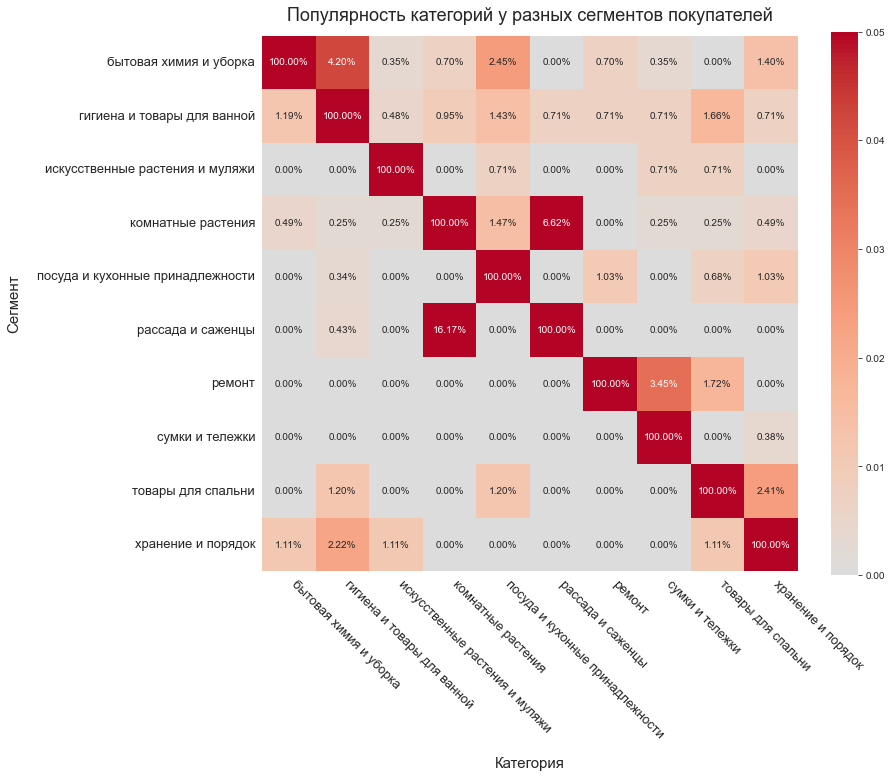

In [45]:
popular_cats_in_segs = plt.figure(figsize=(12, 10))
ax = sns.heatmap(recomendations, vmax=0.05, cmap='coolwarm', center=0, annot=True, fmt='.2%', square=True)

plt.title('Популярность категорий у разных сегментов покупателей', fontsize=18, pad=15)
plt.xlabel('Категория', fontsize=15, labelpad=16)
plt.ylabel('Сегмент', fontsize=15, labelpad=16)
plt.xticks(rotation=315, ha="left", fontsize=13)
plt.yticks(fontsize=13)

plt.show()

Как видно, кроме садовых и комнатых растений, никакие сегменты и категории не коррелируют сильнее 5%. Для удобства запишем самые сильные связи в отдельную таблицу:

In [46]:
strongest_corrs_data = {
    'Сегмент': ['рассада и саженцы', 'комнатные растения', 'бытовая химия и уборка', 'ремонт', 'бытовая химимя и уборка'],
    'Категория': ['комнатные растения', 'рассада и саженцы', 'гигиена и товары для ванной', 'сумки и тележки',
                 'посуда и кухонные принадлежности'],
    'Корреляция': ['16,2%', '6,6%', '4,2%', '3,5%', '2,5%']}

strongest_corrs = pd.DataFrame(data=strongest_corrs_data)

strongest_corrs

,Сегмент,Категория,Корреляция
0,рассада и саженцы,комнатные растения,"16,2%"
1,комнатные растения,рассада и саженцы,"6,6%"
2,бытовая химия и уборка,гигиена и товары для ванной,"4,2%"
3,ремонт,сумки и тележки,"3,5%"
4,бытовая химимя и уборка,посуда и кухонные принадлежности,"2,5%"


[К содержанию](#Содержание)

Перед подведением итогов выгрузим очищенные данные, чтобы построить по ним дашборд.

In [47]:
ecom.to_csv('ecommerce_clean_dataset.csv', sep='\t')

## 5. Выводы<a name="5.-Выводы"></a>

В начале проекта мы познакомились с данными, нашли и исправили в них следующие проблемы:
- неправильные типу у многих признаков,
- дубликаты,
- выбросы.

Отметим большое число дубликатов: они составяли 27% исходных данных. Скорее всего, это свяазно с тем, что у магазина неправильно работает система учета заказов. На это указывает то, что дубликаты были не полными — они различались датами, причем разница была небольшая. Возможно, это значит, что в таблицу записываются разные статусы заказа: например «принят в обработку», «отправлен«, «прибыл в пункт выдачи». Стоит обсудить этот момент с разработчиками.

Затем мы провели исследовательский анализ данных. 

Оказалось, что мы располагаем данными за период с 1 октября 2018 года до 31 октября 2019 года, то есть за 13 месяцев. За это время в магазин обратились 2277 покупателей, которые сделали 2580 заказов. То есть в среднем клиенты приходят к нам не чаще раза в год.

Чтобы в будущем сегментировать клиентов, мы разделили купленные товары на категории. Машинное обучения нам не помогло, поэтому пришлось классифицировать товары самим. Дальше мы исследовали категории товаров.

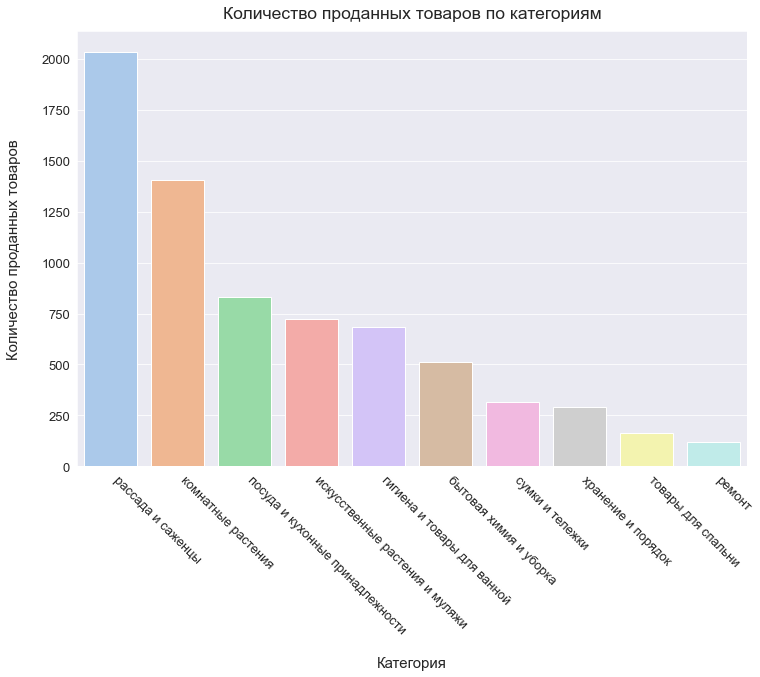

,category,quantity,share
0,рассада и саженцы,2034,28.73%
1,комнатные растения,1404,19.83%
2,посуда и кухонные принадлежности,830,11.72%
3,искусственные растения и муляжи,725,10.24%
4,гигиена и товары для ванной,683,9.65%


In [48]:
display(categories_quantity_plot)
display(categories_quantity.head(5))

Почти половину купленных товаров составляют садовые и комнатные растения. За ними идут посуда и кухонные принадлежности, искусственные растения и муляжки и товары для ванной. Каждая из трех категорий составляет примерно 10% проданных товаров.

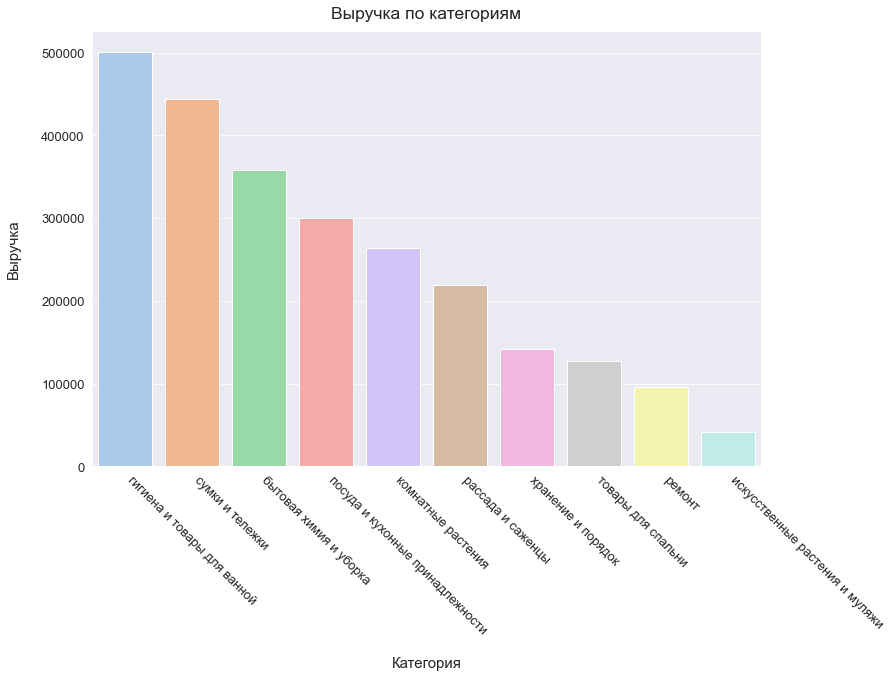

,category,total_position_cost,share
0,гигиена и товары для ванной,500762.0,20.1%
1,сумки и тележки,444166.0,17.83%
2,бытовая химия и уборка,358093.0,14.38%
3,посуда и кухонные принадлежности,299639.0,12.03%
4,комнатные растения,263796.0,10.59%


In [49]:
display(categories_revenue_plot)
display(categories_revenue.head(5))

Самые большие доли выручки принесли не самые крупные по числу проданных товаров категории. Это связано с тем, что популярные товары, как правило дешевые:

In [50]:
category_mean_price.head(5)

,price
category,
искусственные растения и муляжи,70.447699
рассада и саженцы,120.500000
комнатные растения,188.855153
посуда и кухонные принадлежности,485.949495
гигиена и товары для ванной,814.400369


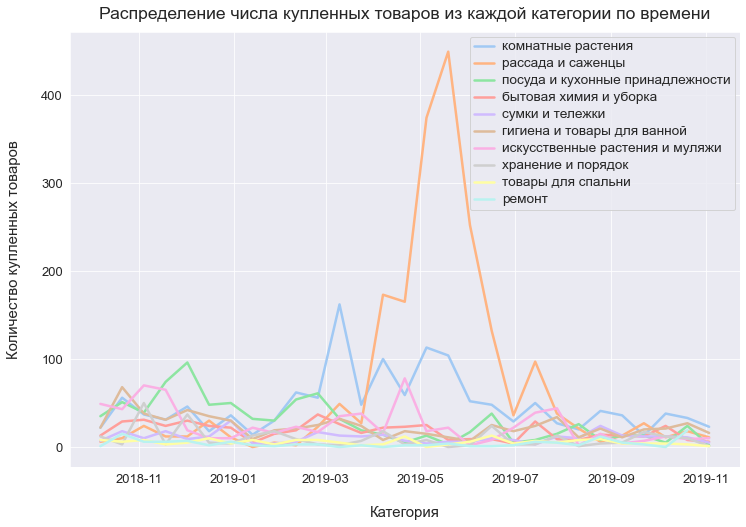

In [51]:
purchases_per_cat

Также мы обнаружили сезонность продаж в категориях товаров, связанных с живыми растениями. Они легко объясняются:
- рассада популярна в теплое время года, когда и выращивают цветы, фрукты и овоащи;
- пик продаж комнатных растений пришелся на начало марта, когда все дарят женщинам цветы в честь их Международного дня.

После исследования категорий мы поделили клиентов на сегменты на основе их покупок. Сегмент клиенту назначался по той категории, в которой он купил больше всего товаров. Этот параметр мы выбрали по тому, что для таргетинга важно подобрать как можно больше релевантных, а не самых дорогих товаров. Число покупок в категории лучше отражает заинтересованность клиента в ней, чем потраченная сумма.

Затем мы посмотрели, какие категории популярны у разных сегментов покупателей и выписали самые сильные корреляции.

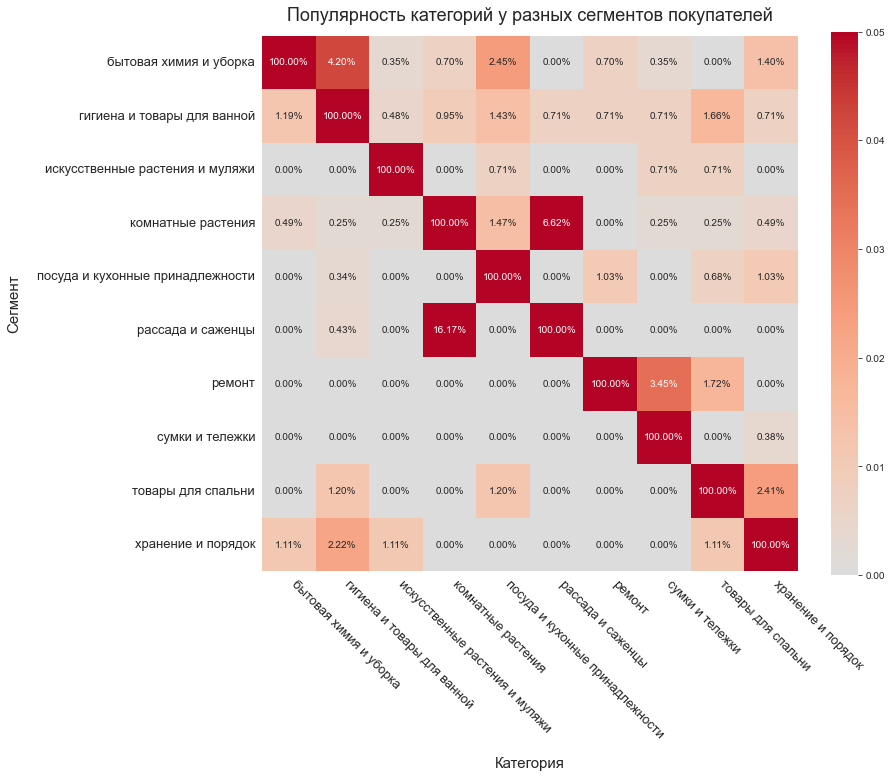

,Сегмент,Категория,Корреляция
0,рассада и саженцы,комнатные растения,"16,2%"
1,комнатные растения,рассада и саженцы,"6,6%"
2,бытовая химия и уборка,гигиена и товары для ванной,"4,2%"
3,ремонт,сумки и тележки,"3,5%"
4,бытовая химимя и уборка,посуда и кухонные принадлежности,"2,5%"


In [52]:
display(popular_cats_in_segs)
strongest_corrs

Также мы нашли самые популярные товары в категориях, чтобы таргетологи знали, какие товары предлагать в объявлениях.

In [53]:
for category in cat_list:
    top_products = (ecom[ecom['category']==category]
                    .groupby('product')['customer_id']
                    .nunique()
                    .reset_index()
                    .rename(columns={
                        'customer_id':'n_buyers'})
                    .sort_values(by='n_buyers', ascending=False)
                    .reset_index(drop=True)
                    .head(5))
    print()
    print('\033[1m' + 'Топ-5 популярных товаров в категории "' + category + '"' + '\033[0m')
    display(top_products)


Топ-5 популярных товаров в категории "комнатные растения"


,product,n_buyers
0,Пеларгония розебудная Red Pandora укорененный черенок,63
1,Пеларгония розебудная Prins Nikolai укорененный черенок,54
2,Пеларгония зональная диам. 12 см сиреневый полумахровый,47
3,Пеларгония розебудная Mary укорененный черенок,35
4,Пеларгония розебудная Margaretha укорененный черенок,29



Топ-5 популярных товаров в категории "рассада и саженцы"


,product,n_buyers
0,"Однолетнее растение Петуния махровая в кассете 4 шт, Россия",19
1,Петуния махровая рассада однолетних цветов в кассете по 6 шт,15
2,Петуния махровая рассада однолетних цветов в кассете по 10 шт,13
3,Рассада зелени для кухни Розмарина в горшке диам. 9 см,13
4,Рассада зелени для кухни Розмарин Блю Лагун диам. 9 см,13



Топ-5 популярных товаров в категории "посуда и кухонные принадлежности"


,product,n_buyers
0,"Кувшин пластмассовый с крышкой ""Кумган"" 2,0 л 1408003",5
1,"Измельчитель овощей ручной ШК-4 деревянный, 3 ножа, 1516020",4
2,Салатник Luminarc КУТЮР 27 см H3529,4
3,Контейнер для овощей Полимербыт 3-х секционный лоток 9 л 4312600,3
4,"Коврик интерьерный для кухни La Bruschetta из ПВХ прямоугольный 45х75 см, Apache, 4661",3



Топ-5 популярных товаров в категории "бытовая химия и уборка"


,product,n_buyers
0,Подкладка под чехол Zalger 520114 135х50 см войлок,7
1,Гладильная доска НИКА BLUES 124х46 см 5757,7
2,Подкладка под чехол Zalger 520140 135х50 см поролон,6
3,Подрукавник складной Ника П,6
4,"Гладильная доска НИКА ДСП ЭКОНОМ 106,5х29 ЭК1",6



Топ-5 популярных товаров в категории "сумки и тележки"


,product,n_buyers
0,Сумка-тележка 2-х колесная Gimi Argo синяя,43
1,Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,16
2,Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,14
3,Тележка багажная DELTA ТБР-20 черный с серым грузоподъемность 25 кг сумка 50 кг каркас РОССИЯ,10
4,Сумка-тележка 2-х колесная складная Gimi Flexi зеленая,10



Топ-5 популярных товаров в категории "гигиена и товары для ванной"


,product,n_buyers
0,Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м,16
1,"Таз пластмассовый со стиральной доской (Иж), 1404021",10
2,"Сушилка для белья потолочная Лиана 2,0 м 1703009",10
3,"Сушилка для белья потолочная Лиана 2,4 м 1703011",9
4,Сушилка для белья напольная НИКА СБП1/С 18 м,9



Топ-5 популярных товаров в категории "искусственные растения и муляжи"


,product,n_buyers
0,Муляж Баклажан 18 см,10
1,Муляж Зеленое яблоко полиуретан d-6 см,8
2,Муляж Персики мини полиуретан d-6 см,8
3,Муляж Морковь 16 см,6
4,Муляж Желудь 2 шт,6



Топ-5 популярных товаров в категории "хранение и порядок"


,product,n_buyers
0,Полки QWERTY Торонто белый 40х10 см 35х10 см 30х10 см 25х10 см 72015,3
1,Подставка для обуви резиновая Attribute 80x40 см AMC080,3
2,Вешалка-плечики без эссенции цвет тёмно-розовый FWM-002/Quartz pink,3
3,Полки QWERTY Италия белый/серый 40х14х10 см 35х10х10 см 30х7х10 см 72006,3
4,"Корзина пластиковая для белья 40л. с крышкой белая 1840/06, Виолет",2



Топ-5 популярных товаров в категории "товары для спальни"


,product,n_buyers
0,Коврик хлопковый 40х60 см цвета в ассортименте 6194,4
1,"Коврик придверный хлопковый 60х140 см мультиколор, Helex, С04",4
2,"Коврик придверный с дизайном, из резины и кокоса 58,5*89 Gothic Iron Slice / Готический Узор, 4468",4
3,Корзина для белья ВИОЛЕТ с крышкой Ротанг 40 л латте 1840/20,3
4,"Коврик придверный MOHAWK Mansonry Foliage Листопад 58,5х89 см 5412",3



Топ-5 популярных товаров в категории "ремонт"


,product,n_buyers
0,"Стяжка оконная с болтом СТ-55 цинк, 1108354",3
1,Стремянка 5 ступенчатая Hailo 8925-901 L9 алюминиевая,2
2,Стремянка COLOMBO FACTOTUM 4 ступени стальная G110L04W,2
3,Стремянка DOGRULAR КЛАСС ПЛЮС 4 ступени 123304,2
4,Стремянка бытовая Framar Slimmy 4 ступени,2


В конце мы проверили гипотезу о том, что в октябре у магазина упал средний чек год к году. К сожалению, эта гипотеза подтвердилась — падение составило больше 37%.

### Рекомендации<a name="Рекомендации"></a>

Мы обнаружили, что у «Пока всё ещё здесь» низкий ретеншн: в среднем клиенты делают один заказ в год. Стоит изучить маркетинговую активность и улучшить ее.

Думаю, подойдут как классические способы (реклама в соцсетях, рассылки и акционные предложения), так и модный сейчас контент-маркетинг. Почти половина купленных товаров — это растения, и люди часто обращаются в интернет, чтобы узнать, как за ними ухаживать. Наш сайт/блог/аккаунт в соцсети может быть об этом. Эти материалы можно будет и таргетировать. 

Также для таргетинга стоит пользоваться составленной матрицей «сегмент — популярные товары» и рекомендовать самые популярные товары в категориях.

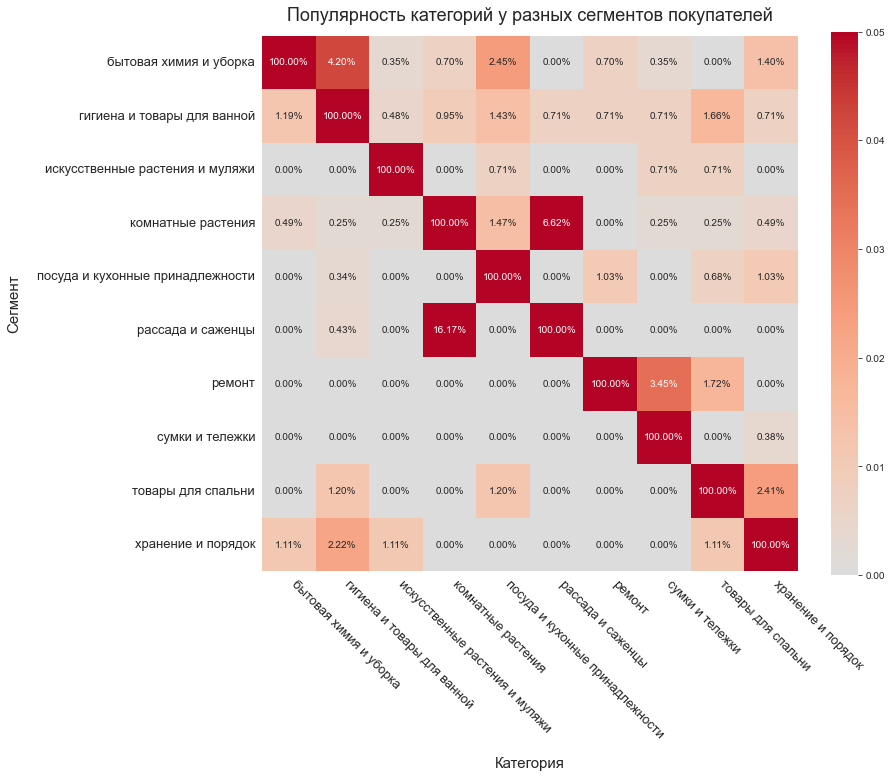


Топ-5 популярных товаров в категории "комнатные растения"


,product,n_buyers
0,Пеларгония розебудная Red Pandora укорененный черенок,63
1,Пеларгония розебудная Prins Nikolai укорененный черенок,54
2,Пеларгония зональная диам. 12 см сиреневый полумахровый,47
3,Пеларгония розебудная Mary укорененный черенок,35
4,Пеларгония розебудная Margaretha укорененный черенок,29



Топ-5 популярных товаров в категории "рассада и саженцы"


,product,n_buyers
0,"Однолетнее растение Петуния махровая в кассете 4 шт, Россия",19
1,Петуния махровая рассада однолетних цветов в кассете по 6 шт,15
2,Петуния махровая рассада однолетних цветов в кассете по 10 шт,13
3,Рассада зелени для кухни Розмарина в горшке диам. 9 см,13
4,Рассада зелени для кухни Розмарин Блю Лагун диам. 9 см,13



Топ-5 популярных товаров в категории "посуда и кухонные принадлежности"


,product,n_buyers
0,"Кувшин пластмассовый с крышкой ""Кумган"" 2,0 л 1408003",5
1,"Измельчитель овощей ручной ШК-4 деревянный, 3 ножа, 1516020",4
2,Салатник Luminarc КУТЮР 27 см H3529,4
3,Контейнер для овощей Полимербыт 3-х секционный лоток 9 л 4312600,3
4,"Коврик интерьерный для кухни La Bruschetta из ПВХ прямоугольный 45х75 см, Apache, 4661",3



Топ-5 популярных товаров в категории "бытовая химия и уборка"


,product,n_buyers
0,Подкладка под чехол Zalger 520114 135х50 см войлок,7
1,Гладильная доска НИКА BLUES 124х46 см 5757,7
2,Подкладка под чехол Zalger 520140 135х50 см поролон,6
3,Подрукавник складной Ника П,6
4,"Гладильная доска НИКА ДСП ЭКОНОМ 106,5х29 ЭК1",6



Топ-5 популярных товаров в категории "сумки и тележки"


,product,n_buyers
0,Сумка-тележка 2-х колесная Gimi Argo синяя,43
1,Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,16
2,Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,14
3,Тележка багажная DELTA ТБР-20 черный с серым грузоподъемность 25 кг сумка 50 кг каркас РОССИЯ,10
4,Сумка-тележка 2-х колесная складная Gimi Flexi зеленая,10



Топ-5 популярных товаров в категории "гигиена и товары для ванной"


,product,n_buyers
0,Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м,16
1,"Таз пластмассовый со стиральной доской (Иж), 1404021",10
2,"Сушилка для белья потолочная Лиана 2,0 м 1703009",10
3,"Сушилка для белья потолочная Лиана 2,4 м 1703011",9
4,Сушилка для белья напольная НИКА СБП1/С 18 м,9



Топ-5 популярных товаров в категории "искусственные растения и муляжи"


,product,n_buyers
0,Муляж Баклажан 18 см,10
1,Муляж Зеленое яблоко полиуретан d-6 см,8
2,Муляж Персики мини полиуретан d-6 см,8
3,Муляж Морковь 16 см,6
4,Муляж Желудь 2 шт,6



Топ-5 популярных товаров в категории "хранение и порядок"


,product,n_buyers
0,Полки QWERTY Торонто белый 40х10 см 35х10 см 30х10 см 25х10 см 72015,3
1,Подставка для обуви резиновая Attribute 80x40 см AMC080,3
2,Вешалка-плечики без эссенции цвет тёмно-розовый FWM-002/Quartz pink,3
3,Полки QWERTY Италия белый/серый 40х14х10 см 35х10х10 см 30х7х10 см 72006,3
4,"Корзина пластиковая для белья 40л. с крышкой белая 1840/06, Виолет",2



Топ-5 популярных товаров в категории "товары для спальни"


,product,n_buyers
0,Коврик хлопковый 40х60 см цвета в ассортименте 6194,4
1,"Коврик придверный хлопковый 60х140 см мультиколор, Helex, С04",4
2,"Коврик придверный с дизайном, из резины и кокоса 58,5*89 Gothic Iron Slice / Готический Узор, 4468",4
3,Корзина для белья ВИОЛЕТ с крышкой Ротанг 40 л латте 1840/20,3
4,"Коврик придверный MOHAWK Mansonry Foliage Листопад 58,5х89 см 5412",3



Топ-5 популярных товаров в категории "ремонт"


,product,n_buyers
0,"Стяжка оконная с болтом СТ-55 цинк, 1108354",3
1,Стремянка 5 ступенчатая Hailo 8925-901 L9 алюминиевая,2
2,Стремянка COLOMBO FACTOTUM 4 ступени стальная G110L04W,2
3,Стремянка DOGRULAR КЛАСС ПЛЮС 4 ступени 123304,2
4,Стремянка бытовая Framar Slimmy 4 ступени,2


In [54]:
display(popular_cats_in_segs)

for category in cat_list:
    top_products = (ecom[ecom['category']==category]
                    .groupby('product')['customer_id']
                    .nunique()
                    .reset_index()
                    .rename(columns={
                        'customer_id':'n_buyers'})
                    .sort_values(by='n_buyers', ascending=False)
                    .reset_index(drop=True)
                    .head(5))
    print()
    print('\033[1m' + 'Топ-5 популярных товаров в категории "' + category + '"' + '\033[0m')
    display(top_products)

[К содержанию](#Содержание)